Step 1: Mathematical Initialization



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Dimensions
n, d = 50, 30
M = 100  # Number of iterations

# 2. Generate Fixed Design Matrix X ~ N(0, 1)
# This stays constant across all 100 iterations
X = np.random.normal(0, 1, (n, d))

# 3. Task 1: Generate Heterogeneous True Parameter theta*
theta_star = np.zeros(d)
theta_star[:10] = np.random.uniform(0.5, 1.0, 10)  # Strong signals
theta_star[10:] = np.random.uniform(0.0, 0.3, 20)  # Weak signals

# 4. Define Lambda Grid
lambdas = np.linspace(0, 25, 51)  # {0, 0.5, 1.0, ..., 25.0}

The Monte Carlo Loop (Task 2 & 3)

In [ ]:
# Initialize storage for MSE results
mse_results = []

# Pre-calculate Gram Matrix (Sigma_hat)
Sigma_hat = (1/n) * (X.T @ X)

for lam in lambdas:
    iteration_errors = []

    for i in range(M):
        # Generate random noise epsilon ~ N(0, I)
        epsilon = np.random.normal(0, 1, n)

        # Generate Observations Y
        Y = X @ theta_star + epsilon

        # Task 2: Compute Ridge Estimator using closed-form solution
        # Formula: theta_hat = (1/n) * (Sigma_hat + lam*I)^-1 * X.T * Y
        inv_term = np.linalg.inv(Sigma_hat + lam * np.eye(d))
        theta_hat = (1/n) * inv_term @ X.T @ Y

        # Calculate Squared Euclidean Distance
        error = np.linalg.norm(theta_hat - theta_star)**2
        iteration_errors.append(error)

    # Task 3: Calculate Empirical MSE(lambda)
    mse_results.append(np.mean(iteration_errors))

# Convert to array for easier plotting
mse_results = np.array(mse_results)

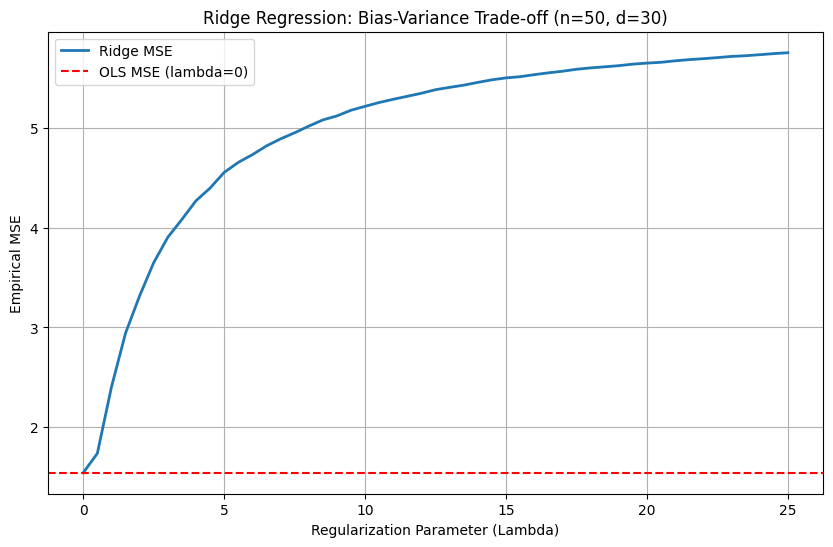

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_results, label='Ridge MSE', linewidth=2)
plt.axhline(y=mse_results[0], color='r', linestyle='--', label='OLS MSE (lambda=0)')

plt.title(f'Ridge Regression: Bias-Variance Trade-off (n={n}, d={d})')
plt.xlabel('Regularization Parameter (Lambda)')
plt.ylabel('Empirical MSE')
plt.grid(True)
plt.legend()
plt.show()

Task 4:Data-Driven Parameter Selection

In [ ]:
def cross_validation_ridge(X, Y, lambdas, K=5):
    n, d = X.shape
    fold_size = n // K
    indices = np.arange(n)
    np.random.shuffle(indices)

    cv_errors = []

    for lam in lambdas:
        fold_errors = []
        for k in range(K):
            # 1. Split data into Training and Validation sets
            val_idx = indices[k * fold_size : (k + 1) * fold_size]
            train_idx = np.setdiff1d(indices, val_idx)

            X_train, Y_train = X[train_idx], Y[train_idx]
            X_val, Y_val = X[val_idx], Y[val_idx]

            # 2. Train Ridge Model on K-1 folds
            n_train = len(X_train)
            Sigma_train = (1/n_train) * (X_train.T @ X_train)

            # Formula: (Sigma + lam*I)^-1 * (1/n * X.T * Y)
            inv_term = np.linalg.inv(Sigma_train + lam * np.eye(d))
            theta_hat_cv = (1/n_train) * inv_term @ X_train.T @ Y_train

            # 3. Compute Validation Risk (MSE on unseen fold)
            predictions = X_val @ theta_hat_cv
            val_mse = np.mean((Y_val - predictions)**2)
            fold_errors.append(val_mse)

        # Average error across all K folds for this lambda
        cv_errors.append(np.mean(fold_errors))

    # Find lambda that minimizes CV error
    best_lambda_idx = np.argmin(cv_errors)
    return lambdas[best_lambda_idx], cv_errors

# --- Execute Task 4 ---
# We use a single realization of Y (as a practitioner would)
epsilon_single = np.random.normal(0, 1, n)
Y_observed = X @ theta_star + epsilon_single

best_lambda, cv_curve = cross_validation_ridge(X, Y_observed, lambdas)

print(f"The Data-Driven Optimal Lambda (Task 4) is: {best_lambda}")

The Data-Driven Optimal Lambda (Task 4) is: 0.5


 Visualizing the CV **result**

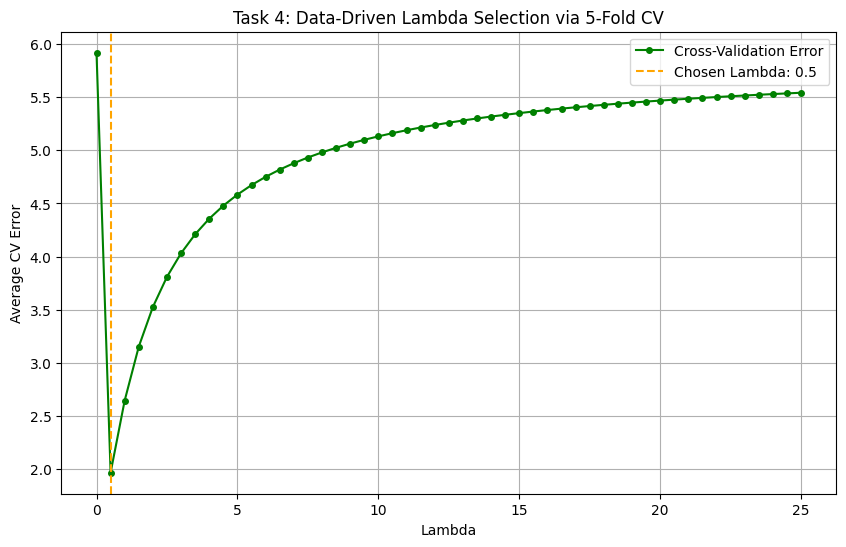

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambdas, cv_curve, label='Cross-Validation Error', color='green', marker='o', markersize=4)
plt.axvline(x=best_lambda, color='orange', linestyle='--', label=f'Chosen Lambda: {best_lambda}')

plt.title('Task 4: Data-Driven Lambda Selection via 5-Fold CV')
plt.xlabel('Lambda')
plt.ylabel('Average CV Error')
plt.legend()
plt.grid(True)
plt.show()

Task 5: Scenario Comparison (Homogeneous Signals)

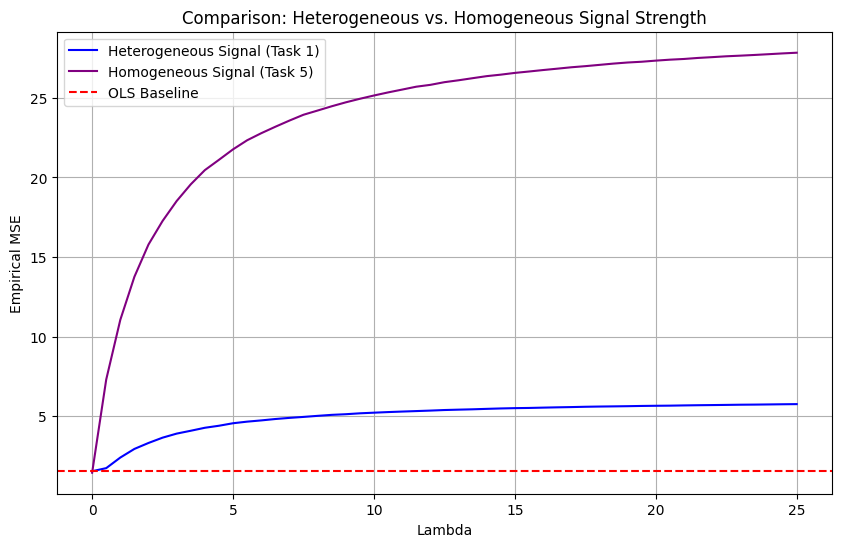

In [ ]:
# --- Task 5: Homogeneous Signal Setup ---

# 1. Initialize Homogeneous True Parameter theta* = (1, 1, ..., 1)
theta_star_homo = np.ones(d)

# 2. Run Monte Carlo Loop for Homogeneous Case
mse_homo = []

for lam in lambdas:
    iteration_errors = []

    for i in range(M):
        # New noise realization
        epsilon = np.random.normal(0, 1, n)
        Y = X @ theta_star_homo + epsilon

        # Ridge Estimator (Closed-form)
        inv_term = np.linalg.inv(Sigma_hat + lam * np.eye(d))
        theta_hat = (1/n) * inv_term @ X.T @ Y

        # Calculate Squared Euclidean Distance
        error = np.linalg.norm(theta_hat - theta_star_homo)**2
        iteration_errors.append(error)

    mse_homo.append(np.mean(iteration_errors))

mse_homo = np.array(mse_homo)

# --- Visualization for Comparison ---
plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_results, label='Heterogeneous Signal (Task 1)', color='blue')
plt.plot(lambdas, mse_homo, label='Homogeneous Signal (Task 5)', color='purple')
plt.axhline(y=mse_results[0], color='r', linestyle='--', label='OLS Baseline')

plt.title('Comparison: Heterogeneous vs. Homogeneous Signal Strength')
plt.xlabel('Lambda')
plt.ylabel('Empirical MSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Initialize storage
mse_results = []
all_theta_hats = {} # Dictionary to store estimates for visualization

# Pre-calculate Gram Matrix
Sigma_hat = (1/n) * (X.T @ X)

for lam in lambdas:
    iteration_errors = []
    thetas_for_this_lambda = [] # To store individual theta_hats

    for i in range(M):
        epsilon = np.random.normal(0, 1, n)
        Y = X @ theta_star + epsilon

        # Compute Ridge Estimator
        inv_term = np.linalg.inv(Sigma_hat + lam * np.eye(d))
        theta_hat = (1/n) * inv_term @ X.T @ Y

        # Save theta_hat for shrinkage analysis
        thetas_for_this_lambda.append(theta_hat)

        # Calculate Error
        error = np.linalg.norm(theta_hat - theta_star)**2
        iteration_errors.append(error)

    # Store the results
    mse_results.append(np.mean(iteration_errors))
    all_theta_hats[lam] = np.array(thetas_for_this_lambda)

mse_results = np.array(mse_results)

<>:14: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-1350085545.py:14: SyntaxWarning: invalid escape sequence '\h'
  plt.title('Coefficient-wise Absolute Error |$\hat{\\theta} - \\theta^*$| (Task 3 & 6)')


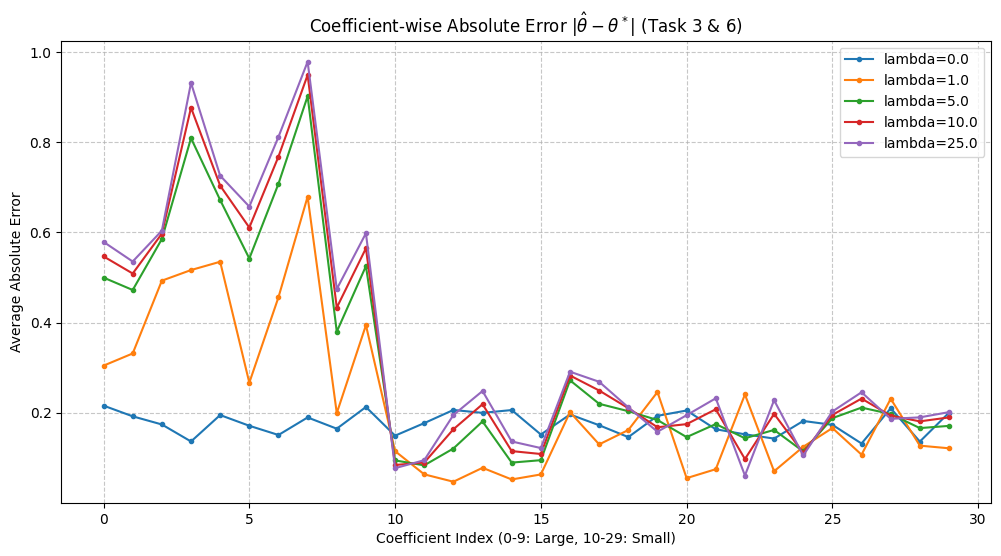

In [ ]:
import matplotlib.pyplot as plt


selected_lams = [0.0, 1.0, 5.0, 10.0, 25.0]

plt.figure(figsize=(12, 6))

for lam in selected_lams:
    if lam in all_theta_hats:
        # Calculate mean absolute error per coefficient across M iterations
        avg_abs_error = np.mean(np.abs(all_theta_hats[lam] - theta_star), axis=0)
        plt.plot(range(d), avg_abs_error, label=f'lambda={lam}', marker='o', markersize=3)

plt.title('Coefficient-wise Absolute Error |$\hat{\\theta} - \\theta^*$| (Task 3 & 6)')
plt.xlabel('Coefficient Index (0-9: Large, 10-29: Small)')
plt.ylabel('Average Absolute Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()